In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from lal import MSUN_SI, C_SI, G_SI

# Choice of units $c=G=M_\odot=1$

A convenient choice of units to work with is $c=G=M_\odot=1$. To covert cgs units to this and vice-versa is given [here](https://www.icts.res.in/sites/default/files/gws2017-Hinderer-Tutorial4.pdf) in the appendix

In [3]:
Msun = MSUN_SI * 1e3
C = C_SI * 1e2
G = G_SI * 1e6 / 1e3

### Conversion from cgs to $c=G=M_\odot=1$

The starred values are in $c=G=M_\odot=1$ which corresponds to the non-starred values in cgs uints
$$d^\star = d/M^\star_\odot$$
$$\rho^\star = \rho G {M^\star}^2/c^2$$
$$p^\star = p G {M^\star}^2/c^4$$

where $M_\odot^\star = G M_\odot/c^2$ is the mass of sun in geometrized units $c=G=1$.

In [4]:
msun_geom = G * Msun/C**2
length_factor = 1/msun_geom
density_factor = G * msun_geom**2/C**2
pressure_factor = density_factor/C**2

# Downlaod and load data for equation of state

For an example we will use the "SLy" equation of state. Tabulated data could be found [here](http://www.ioffe.ru/astro/NSG/NSEOS/sly4.dat). the last two columns are the density and pressure in cgs units.

In [5]:
#!wget http://www.ioffe.ru/astro/NSG/NSEOS/sly4.dat

In [6]:
rho, p = np.loadtxt("sly4.dat", usecols=(2,3), unpack=True)
rho = rho * density_factor  # we have to convert the units from cgs to $c=G=M_\odot=1$
p = p * pressure_factor  # similarly convert units

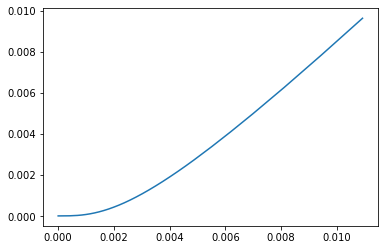

In [7]:
plt.plot(rho, p)

## Interpolate the denisty and pressure 

In [8]:
logrho_interp = interp1d(np.log(p), np.log(rho), kind="cubic", fill_value="extrapolate")  # since the order varies a lot we interpolate in logspace
logp_interp = interp1d(np.log(rho), np.log(p), kind="cubic", fill_value="extrpolate")
def p_interp(rho):
    return np.exp(logp_interp(np.log(abs(rho))))
def rho_interp(p):
    return np.exp(logrho_interp(np.log(abs(p))))

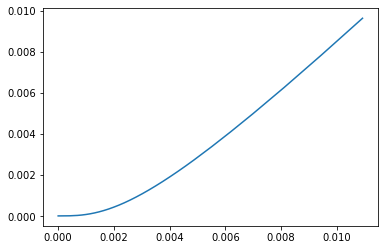

In [9]:
plt.plot(rho, p_interp(rho))

# Solve TOV

## Define the TOV odes 

In [10]:
def tov(r, y):
    m, p = y
    rho = rho_interp(p)
    dpdr = ((m + 4 * np.pi * r**3 * p)
            * (rho + p)
            / (r * (2 * m - r)))
    dmdr = 4 * np.pi * rho * r**2
    return [dmdr, dpdr]

## Prescribe our events for the solver
We want to find where pressure hits zero which represents the surface of the star.

In [11]:
def hit_surface(r, y):
    return y[1]

hit_surface.terminal = True

In [12]:
rhoc = 1e15 * density_factor  # We choose central density of 1e15 in cgs unit which we then convert to our working units
pc = p_interp(rhoc)  # central pressure
rmax = 1e9 * length_factor  # We provide upper limit of integration as 1e9 cm, i.e 10000 km which is more than enough
rspan = [1e-10, rmax]  # we start from small nonzero value of r
r_eval = np.linspace(rspan[0], rspan[-1], 100000)  # radii where we want the solutions

In [13]:
sol = solve_ivp(tov, rspan, [0, pc], t_eval=r_eval, method="Radau",
                events=hit_surface)

In [14]:
sol.t_events[0]

array([7.6484952])

Text(0, 0.5, 'p')

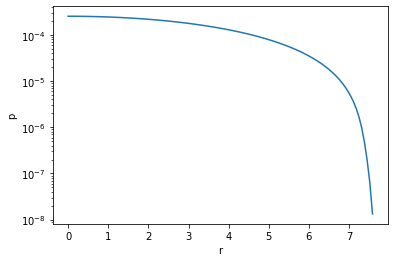

In [15]:
plt.semilogy(sol.t, sol.y[1])
plt.xlabel("r")
plt.ylabel("p")

Text(0, 0.5, 'rho')

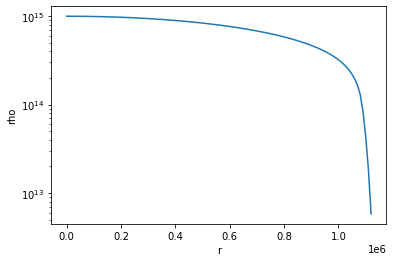

In [16]:
plt.semilogy(sol.t/length_factor, rho_interp(sol.y[1]) / density_factor)
plt.xlabel("r")
plt.ylabel("rho")

In [17]:
p_interp(1e2 * density_factor)

1.9457998200986684e-24

In [18]:
sol.y_events

[array([[1.42018708e+00, 2.48154184e-23]])]

In [19]:
sol.t_events

[array([7.6484952])]

In [20]:
Rstar = (sol.t_events[0]/length_factor)/1e5  # in km
Rstar

array([11.2939597])

In [21]:
massfactor = G/(msun_geom * C**2)
Mstar = (sol.y_events[0][0][0]/massfactor)/Msun  # in solar mass
Mstar

1.4201870847868647

# Vary the central density to get maximum mass and radius for the equation of state

In [22]:
rhocs = 10**np.linspace(14, np.log10(6.7 * 1e15), 100) * density_factor
masses = np.zeros(len(rhocs))
radii = np.zeros(len(rhocs))

for idx, rhoc in enumerate(rhocs):
    pc = p_interp(rhoc)  # central pressure
    solution = solve_ivp(tov, rspan, [0, pc], t_eval=r_eval, method="Radau", events=hit_surface)
    # print(solution.t_events)
    # print(solution.y_events[0][0][0])
    masses[idx] = solution.y_events[0][0][0]
    radii[idx] = solution.t_events[0]

In [23]:
radii_SI = (radii/length_factor)/1e5  # convert radii to kms

In [24]:
masses_MSun = (masses/massfactor)/Msun  # convert mass to solar mass

In [25]:
MaxMass = max(masses_MSun)
maxid = np.argmax(masses_MSun)
RstarMaxMass = radii_SI[maxid]
print(f"Maximum mass = {MaxMass}, Radius = {RstarMaxMass}")

Maximum mass = 2.0501850461579147, Radius = 9.868783542810185


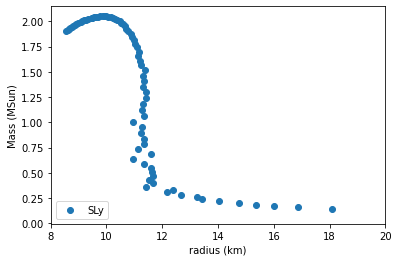

In [26]:
plt.scatter(radii_SI, masses_MSun, label="SLy")
plt.xlim(8, 20)
plt.xlabel("radius (km)")
plt.ylabel("Mass (MSun)")
plt.legend(loc="lower left")

## TASK: Find the mass-radius relation for different EOS

For different equation of states repeat the analysis and make plot showing the mass-radius relation for different equation of states